Import Libraries

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
import re
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

from nltk.tokenize import word_tokenize, sent_tokenize

import spacy
from spacy import displacy

import random
import matplotlib

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Uploading and reading the dataset

In [2]:
from google.colab import files
uploaded = files.upload()

Saving spam.csv to spam (3).csv


In [3]:
df = pd.read_csv("spam (3).csv", encoding='latin1')
df.drop(df.columns[[2,3,4]], axis = 1, inplace = True)
df.columns = ['Target','SMS']
df.head()

,Target,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Basic understanding of the data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Target  5572 non-null   object
 1   SMS     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [5]:
df.shape

(5572, 2)

In [6]:
sms = pd.DataFrame()
sms['count_characters'] = df['SMS'].apply(len)
sms["count_words"]= df.apply(lambda x: nltk.word_tokenize(x["SMS"]), axis=1).apply(len)
sms["No_of_sentence"]=df.apply(lambda row: nltk.sent_tokenize(row["SMS"]), axis=1).apply(len)

In [7]:
sms.describe()

,count_characters,count_words,No_of_sentence
count,5572.000000,5572.000000,5572.000000
mean,80.118808,18.501256,1.991565
std,59.690841,13.637056,1.501427
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,61.000000,15.000000,1.500000
75%,121.000000,27.000000,2.000000
max,910.000000,219.000000,38.000000


EDA of the Dataset

In [8]:
temp = pd.DataFrame()
temp['Target'] = ['Ham','Spam']
temp['Count'] = [len(df[df['Target'] == 'ham']), len(df[df['Target'] == 'spam'])]
temp = temp.sort_values(by = ['Count'], ascending = False)
fig = px.bar(temp, x = 'Target', y = 'Count', 
             color = "Target", text_auto='', width = 600, 
             color_discrete_sequence = ["#AB63FA", "orange"],
             template = 'plotly_dark',
            title = "Count Plot")

fig.update_xaxes(showgrid = False)
fig.update_yaxes(showgrid = False)
fig.update_traces(textfont_size=12, textangle = 0, textposition = "outside", cliponaxis = False)
fig.show()

In [9]:
fig = px.pie(temp, values = 'Count', names = 'Target', width = 600, 
             color = 'Target', color_discrete_map = {'Ham': 'rgb(166, 216, 84)', 'Spam': 'rgb(228, 26, 28)'},
             template = 'plotly_dark', title = "Pie Chart")
fig.show()

In [10]:
df['no_of_chars'] = df['SMS'].apply(len)
df['no_of_words'] = df['SMS'].apply(lambda x: len(nltk.word_tokenize(x)))
df['no_of_sents'] = df['SMS'].apply(lambda x: len(nltk.sent_tokenize(x)))
df['Temp'] = df['Target'].map({'ham': 0, 'spam': 1})

df.head()

,Target,SMS,no_of_chars,no_of_words,no_of_sents,Temp
0,ham,"Go until jurong point, crazy.. Available only ...",111,23,2,0
1,ham,Ok lar... Joking wif u oni...,29,8,2,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,1
3,ham,U dun say so early hor... U c already then say...,49,13,1,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,0


In [11]:
fig = px.histogram(df, x = 'no_of_chars', color = 'Target', 
                   template = 'plotly_dark', 
                   title = "Histogram for HAM vs SPAM based on Number of Characters per Message")

fig.update_xaxes(showgrid = False)
fig.update_yaxes(showgrid = False)
fig.update_layout(barmode = 'overlay')
fig.show()

In [12]:
fig = px.histogram(df, x = 'no_of_words', color = 'Target', 
                   template = 'plotly_dark', 
                   title = "Histogram for HAM vs SPAM based on Number of Words per Message")

fig.update_xaxes(showgrid = False)
fig.update_yaxes(showgrid = False)
fig.update_layout(barmode = 'overlay')
fig.show()

In [13]:
fig = px.histogram(df, x = 'no_of_sents', color = 'Target', template = 'plotly_dark', title = "Histogram for HAM vs SPAM based on Number of Sentences per Message")
fig.update_xaxes(showgrid = False)
fig.update_yaxes(showgrid = False)
fig.update_layout(barmode = 'overlay')
fig.show()

In [14]:
fig = px.imshow(df.corr(), text_auto = True, color_continuous_scale = 'blues', template = 'plotly_dark', title = "Correlation Matrix")
fig.show()

In [15]:
analysis_sms = pd.DataFrame()
analysis_sms['count_characters'] = df['SMS'].apply(len)
analysis_sms["count_words"]= df.apply(lambda x: nltk.word_tokenize(x["SMS"]), axis=1).apply(len)
analysis_sms["No_of_sentence"]=df.apply(lambda row: nltk.sent_tokenize(row["SMS"]), axis=1).apply(len)
df_with_analysis = df.join(analysis_sms)
df_with_analysis.head()

,Target,SMS,no_of_chars,no_of_words,no_of_sents,Temp,count_characters,count_words,No_of_sentence
0,ham,"Go until jurong point, crazy.. Available only ...",111,23,2,0,111,23,2
1,ham,Ok lar... Joking wif u oni...,29,8,2,0,29,8,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,1,155,37,2
3,ham,U dun say so early hor... U c already then say...,49,13,1,0,49,13,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,0,61,15,1


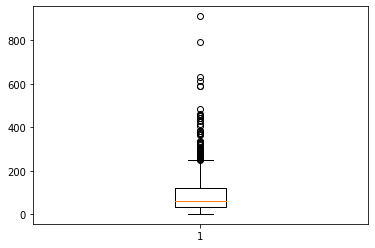

In [16]:
count_character_box_plt = plt.boxplot(df_with_analysis['no_of_chars'])

In [17]:
[item.get_ydata()[1] for item in count_character_box_plt['whiskers']]

[2.0, 248.0]

In [18]:
(df_with_analysis['no_of_chars'] > 248).sum()

68

In [19]:
df_with_analysis = df_with_analysis[(df_with_analysis['no_of_chars'] <= 248)]
df_with_analysis.head()

,Target,SMS,no_of_chars,no_of_words,no_of_sents,Temp,count_characters,count_words,No_of_sentence
0,ham,"Go until jurong point, crazy.. Available only ...",111,23,2,0,111,23,2
1,ham,Ok lar... Joking wif u oni...,29,8,2,0,29,8,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,1,155,37,2
3,ham,U dun say so early hor... U c already then say...,49,13,1,0,49,13,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,0,61,15,1


In [20]:
data = df_with_analysis[['Target', 'SMS']]
le = LabelEncoder()
data["Target"] = le.fit_transform(data["Target"])
print(*data["SMS"][:5], sep = "\n\n")

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Ok lar... Joking wif u oni...

Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

U dun say so early hor... U c already then say...

Nah I don't think he goes to usf, he lives around here though


Removing Stopwords and extra scpaces and puchtuations if any

In [21]:
STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']

In [22]:
def sms_sanitization(sms):
    sms = re.sub('[^a-zA-Z]', ' ', sms)
    sms = sms.lower()
    return ' '.join([word for word in sms.split() if word not in STOPWORDS])

In [23]:
data["sanitized_sms"] = data["SMS"].apply(sms_sanitization)

In [24]:
print(*data["sanitized_sms"][:5], sep = "\n\n")

go jurong point crazy available bugis n great world la e buffet cine got amore wat

ok lar joking wif oni

free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply

dun say early hor c already say

nah think goes usf lives around though


## Using Count Vectorization Technicque

CountVectorizer is a great tool provided by the scikit-learn library in Python. It is used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text.

In [25]:
bow_transformer = CountVectorizer()

bow = bow_transformer.fit_transform(data['sanitized_sms'])

In [26]:
len(bow_transformer.vocabulary_)

7244

In [27]:
print(bow_transformer.get_feature_names()[5504])
print(bow_transformer.get_feature_names()[0])

shake
aa


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [28]:
print('Shape of Sparse Matrix: ', bow.shape)
print('Amount of Non-Zero occurences: ', bow.nnz)

Shape of Sparse Matrix:  (5504, 7244)
Amount of Non-Zero occurences:  42562


Spliiting Data into Train and Test

In [29]:
X_train, X_test, y_train, y_test = train_test_split(bow, data["Target"], test_size=0.33, random_state=42)

#MultinomibalDB

The Multinomial Naive Bayes algorithm is a Bayesian learning approach popular in Natural Language Processing (NLP). The program guesses the tag of a text, such as an email or a newspaper story, using the Bayes theorem. It calculates each tag's likelihood for a given sample and outputs the tag with the greatest chance.

In [30]:
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB()

In [31]:
y_pred = clf.predict(X_test)

In [32]:
def evaluation_parametrics(name, y_train, yp_train, y_test, yp_test):
    
    print("\n-----------------------------{}-----------------------------\n".format(name))
    
    cm_train = confusion_matrix(y_train, yp_train)
    t1 = ConfusionMatrixDisplay(cm_train)
    s1 = round((cm_train[0,0]/(cm_train[0,0] + cm_train[0,1])),4)
    
    print("Classification Report for Train Data\n")
    print(classification_report(y_train, yp_train)) 
    print("--------------------------------------------------------------------------")
    print("Specificity on Train Data: ", s1)
    print("Accuracy on Train Data: ", round(accuracy_score(y_train, yp_train),4))
    print("F1 Score on Train Data: ", round(f1_score(y_train, yp_train),4))
    print("--------------------------------------------------------------------------")
          
    cm_test = confusion_matrix(y_test, yp_test)
    t2 = ConfusionMatrixDisplay(cm_test)
    s2 = round((cm_test[0,0]/(cm_test[0,0] + cm_test[0,1])),4)
    
    print("\nClassification Report for Test Data\n")
    print(classification_report(y_test, yp_test))   
    print("--------------------------------------------------------------------------")
    print("Specificity on Test Data: ", s2)
    print("Accuracy on Test Data: ", round(accuracy_score(y_test, yp_test), 4))
    print("F1 Score Test Data: ", round(f1_score(y_test, yp_test), 4))
    print("--------------------------------------------------------------------------")
    
    t1.plot()
    t2.plot()

In [33]:
confusion_matrix(y_test, y_pred)

array([[1545,   28],
       [  11,  233]])


-----------------------------MultinomialNB-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3184
           1       1.00      1.00      1.00       503

    accuracy                           1.00      3687
   macro avg       1.00      1.00      1.00      3687
weighted avg       1.00      1.00      1.00      3687

--------------------------------------------------------------------------
Specificity on Train Data:  1.0
Accuracy on Train Data:  1.0
F1 Score on Train Data:  1.0
--------------------------------------------------------------------------

Classification Report for Test Data

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1573
           1       1.00      1.00      1.00       244

    accuracy                           1.00      1817
   macro avg       1.00      1.00      1.00      1817
weighted av

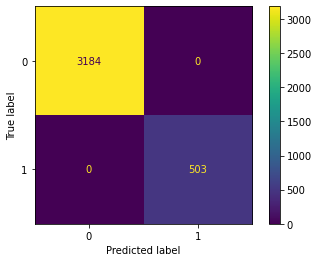

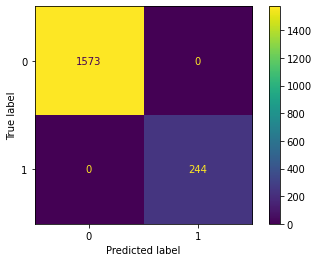

In [34]:
evaluation_parametrics("MultinomialNB", y_train, y_train, y_test, y_test)

In [35]:
# Printing the POS tagging for the first 4 rows of SMS
i = 0
for sms in data['sanitized_sms'][:4]:
    i = i + 1
    # Word tokenizers is used to find the words
    # and punctuation in a string
    wordsList = nltk.word_tokenize(sms)

    #  Using a Tagger. Which is part-of-speech
    # tagger or POS-tagger.
    tagged = nltk.pos_tag(wordsList)
    
    print("\033[1m{0}. {1}\033[0m".format(i, sms))
    print('\033[1mPOS tagging:\033[0m', tagged, '\n')

1. go jurong point crazy available bugis n great world la e buffet cine got amore wat
POS tagging: [('go', 'VB'), ('jurong', 'JJ'), ('point', 'NN'), ('crazy', 'NN'), ('available', 'JJ'), ('bugis', 'NN'), ('n', 'RB'), ('great', 'JJ'), ('world', 'NN'), ('la', 'NN'), ('e', 'VBP'), ('buffet', 'JJ'), ('cine', 'NN'), ('got', 'VBD'), ('amore', 'RB'), ('wat', 'JJ')] 

2. ok lar joking wif oni
POS tagging: [('ok', 'JJ'), ('lar', 'JJ'), ('joking', 'NN'), ('wif', 'NN'), ('oni', 'NN')] 

3. free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply
POS tagging: [('free', 'JJ'), ('entry', 'NN'), ('wkly', 'VBD'), ('comp', 'NN'), ('win', 'NN'), ('fa', 'JJ'), ('cup', 'VBZ'), ('final', 'JJ'), ('tkts', 'NN'), ('st', 'NN'), ('may', 'MD'), ('text', 'VB'), ('fa', 'JJ'), ('receive', 'JJ'), ('entry', 'NN'), ('question', 'NN'), ('std', 'VBD'), ('txt', 'JJ'), ('rate', 'NN'), ('c', 'NNS'), ('apply', 'VBP')] 

4. dun say early hor c already say
POS tagging: [('dun', 'NN

Spacy is an open-source software python library used in advanced natural language processing and machine learning. It will be used to build information extraction, natural language understanding systems, and to pre-process text for deep learning.

In [36]:
# spaCy has different types of models. The default model for the English language is en_core_web_sm. We use this
# Here, the nlp object is a language model instance and it refers to the language model loaded by en_core_web_sm
nlp=spacy.load('en_core_web_sm')
 
text='the series opened 17 years later, as Viserys Targaryen tried to win an eastern tribal army to his side,\
so he could retake the Iron Throne'

# Here we used spaCy to create a processed Doc object, which is a container for accessing linguistic annotations, 
# for a given input string
for token in nlp(text):
 print(token.text, '=>',token.pos_,'=>',token.tag_)

the => DET => DT
series => NOUN => NN
opened => VERB => VBD
17 => NUM => CD
years => NOUN => NNS
later => ADV => RB
, => PUNCT => ,
as => SCONJ => IN
Viserys => PROPN => NNP
Targaryen => PROPN => NNP
tried => VERB => VBD
to => PART => TO
win => VERB => VB
an => DET => DT
eastern => ADJ => JJ
tribal => ADJ => JJ
army => NOUN => NN
to => ADP => IN
his => DET => PRP$
side => NOUN => NN
, => PUNCT => ,
so => ADV => RB
he => PRON => PRP
could => VERB => MD
retake => VERB => VB
the => DET => DT
Iron => PROPN => NNP
Throne => NOUN => NN


In [37]:
displacy.render(nlp(text),jupyter=True)